In [1]:
import phoebe
from phoebe import u

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='WARNING')

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/normalizedTimeseries.csv"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

import os
assert os.path.exists(CONCAT_OBSERVATIONS_CSV), f"{CONCAT_OBSERVATIONS_CSV} not found"

## Observation Data

In [2]:
def printFittedVals(b: phoebe.Bundle, solution: str):
	for param, value, unit in zip(b.get_value('fitted_twigs', solution=solution),
								b.get_value('fitted_values', solution=solution),
								b.get_value('fitted_units', solution=solution)): 
		try:
			print(f"{param} = {value:.2f} {unit}")
		except:
			print(param, value, unit)

def printFittedTwigsConstraints(b: phoebe.Bundle, solution: str):
	for fitTwig in b.get_value('fitted_twigs', solution=solution):
		print(b.filter(fitTwig))

In [3]:
observations = pd.read_csv(CONCAT_OBSERVATIONS_CSV)
observations.head()

,time,mag,err,raw_flux,ferr,detrend_flux,norm_flux,obsv_date,julianDate
0,2022-10-21 22:54:21.841,18.014,0.014,37382.02,482.037653,3264.86,1.109233,2022-10-21,2.459874e+06
1,2022-10-21 22:55:22.219,18.044,0.012,36357.11,401.847030,2239.95,1.074942,2022-10-21,2.459874e+06
2,2022-10-21 22:56:22.714,18.019,0.013,37214.78,445.603887,3097.62,1.103637,2022-10-21,2.459874e+06
3,2022-10-21 22:57:23.081,18.006,0.010,37644.18,346.727273,3527.02,1.118004,2022-10-21,2.459874e+06
4,2022-10-21 22:58:23.606,18.035,0.009,36665.20,303.939210,2548.04,1.085250,2022-10-21,2.459874e+06


In [6]:
jdTime = observations['julianDate']
jdTimeMin, jdTimeMax = jdTime.iloc[0], jdTime.iloc[-1]
observations['julianDate_norm'] = (jdTime - jdTimeMin) / (jdTimeMax - jdTimeMin)
observations

,time,mag,err,raw_flux,ferr,detrend_flux,norm_flux,obsv_date,julianDate,julianDate_norm
0,2022-10-21 22:54:21.841,18.014,0.014,37382.02,482.037653,3264.86,1.109233,2022-10-21,2.459874e+06,0.000000
1,2022-10-21 22:55:22.219,18.044,0.012,36357.11,401.847030,2239.95,1.074942,2022-10-21,2.459874e+06,0.000014
2,2022-10-21 22:56:22.714,18.019,0.013,37214.78,445.603887,3097.62,1.103637,2022-10-21,2.459874e+06,0.000028
3,2022-10-21 22:57:23.081,18.006,0.010,37644.18,346.727273,3527.02,1.118004,2022-10-21,2.459874e+06,0.000042
4,2022-10-21 22:58:23.606,18.035,0.009,36665.20,303.939210,2548.04,1.085250,2022-10-21,2.459874e+06,0.000056
...,...,...,...,...,...,...,...,...,...,...
1172,2022-12-10 20:52:39.875,18.277,0.015,29324.09,405.140785,-5558.93,0.814015,2022-12-10,2.459924e+06,0.999944
1173,2022-12-10 20:53:40.007,18.267,0.018,29610.24,490.913070,-5272.78,0.823588,2022-12-10,2.459924e+06,0.999958
1174,2022-12-10 20:54:40.156,18.312,0.023,28412.02,601.894133,-6471.00,0.783500,2022-12-10,2.459924e+06,0.999972
1175,2022-12-10 20:55:40.318,18.343,0.017,27607.31,432.278042,-7275.71,0.756576,2022-12-10,2.459924e+06,0.999986


In [5]:
# TODO: come up with a more formal way to normalize the flux
normFluxObservations = pd.DataFrame()

for obsvDate in observations['obsv_date'].unique():
    dateObservations = observations[observations['obsv_date'] == obsvDate]
    # maxFlux = np.max(dateObservations['FLUX'].to_numpy())
    # dateObservations['norm_flux'] = dateObservations['FLUX'] / maxFlux
    medianFlux = np.median(dateObservations['FLUX'].to_numpy())
    dateObservations['norm_flux'] = dateObservations['FLUX'] / medianFlux
    normFluxObservations = pd.concat([normFluxObservations, dateObservations])
normFluxObservations

KeyError: 'FLUX'

## PHOEBE initial setup

In [7]:
b = phoebe.default_contact_binary()

In [8]:
b.add_compute(
    compute='fast_compute',
    
    # speed up compute for the sake of the demo; DON'T PUBLISH WITH THESE
    irrad_method='none',
    rv_method='dynamical', # no meshing; compute rvs from first principles
    distortion_method='sphere',
    atm='blackbody',
    overwrite=True
)

<ParameterSet: 36 parameters | components: primary, _default, secondary, contact_envelope>

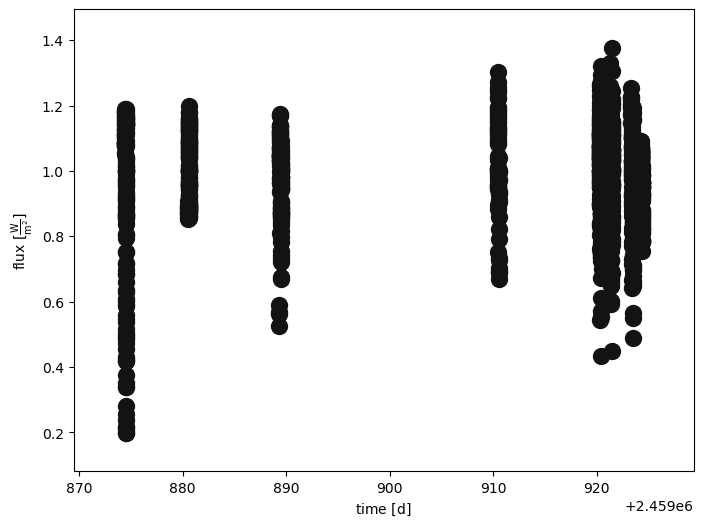

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [9]:
b.add_dataset('lc', times=jdTime.to_numpy()*u.day, fluxes=observations['norm_flux'].to_numpy(), dataset='lc_iturbide', overwrite=True)
# b.add_dataset('lc', times=jdTime.to_numpy()*u.day, fluxes=normFluxObservations['FLUX'].to_numpy(), dataset='lc_iturbide', overwrite=True)
# b.add_dataset('lc', times=observations['JDTIME_Norm'].to_numpy(), fluxes=normFluxObservations['FLUX'].to_numpy(), dataset='lc_iturbide', overwrite=True)
b.plot(dataset='lc_iturbide', show=True)

In [12]:
print(b['pblum_mode']) # original value = component-coupled
print(b['passband'])
# b.set_value(qualifier='pblum_mode', dataset='lc_iturbide', value='absolute')

Parameter: pblum_mode@lc_iturbide@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: component-coupled
                         Choices: decoupled, component-coupled, dataset-coupled, dataset-scaled, absolute
                  Constrained by: 
                      Constrains: None
                      Related to: None

Parameter: passband@lc_iturbide@dataset
                       Qualifier: passband
                     Description: Passband
                           Value: Johnson:V
                         Choices: Johnson:B, Johnson:V, Gaia:G, Bolometric:900-40000, Gaia:BP, Gaia:RP
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [47]:
# Avoid stellar atmosphere errors during estimation
print(b['atm'])
print(b['ld_mode'])
print(b['ld_mode_bol'])

def avoidAtmosphereErrors(b: phoebe.Bundle):
	b.set_value_all(qualifier='ld_mode', dataset='lc_iturbide', value='manual') # original value = interp
	b.set_value_all(qualifier='ld_mode_bol', value='manual') # original value = lookup

def resetAtmosphere(b: phoebe.Bundle):
	b.set_value_all(qualifier='ld_mode', dataset='lc_iturbide', value='interp') # original value = interp
	b.set_value_all(qualifier='ld_mode_bol', value='lookup') # original value = lookup

ParameterSet: 4 parameters
     atm@primary@phoebe01@compute: ck2004
   atm@secondary@phoebe01@compute: ck2004
   atm@primary@fast_compute@co...: blackbody
   atm@secondary@fast_compute@...: blackbody
ParameterSet: 2 parameters
   ld_mode@primary@lc_iturbide...: manual
   ld_mode@secondary@lc_iturbi...: manual
ParameterSet: 2 parameters
    ld_mode_bol@primary@component: manual
   ld_mode_bol@secondary@compo...: manual


## Period estimator
Utilizing Lomb-Scargle algorithm on the normalized light curve

In [10]:
b.add_solver('estimator.lc_periodogram', algorithm='ls', solver='lcperiod', overwrite=True)
b.run_solver('lcperiod', solution='lcperiod_solution', overwrite=True)

print(b['fitted_values@lcperiod_solution'])

Parameter: fitted_values@lcperiod_solution@solution
                       Qualifier: fitted_values
                     Description: final values returned by the minimizer (in current default units of each parameter)
                           Value: [69.7]
                  Constrained by: 
                      Constrains: None
                      Related to: None



ParameterSet: 10 parameters
R  period@lcperiod@lcperiod_so...: [   4.     4.1    4.2 ...
 1176.8 1176.9 1177. ] d
R  power@lcperiod@lcperiod_sol...: [0.29124082 0.21362521
 0.1378426  ... 0.00250717
 0.00148101 0.00067262]
   period_factor@lcperiod@lcpe...: 1.0
R  fitted_twigs@lcperiod@lcper...: ['period@binary@orbit@component']
R  fitted_values@lcperiod@lcpe...: [69.7]
R  fitted_units@lcperiod@lcper...: ['d']
   adopt_parameters@lcperiod@l...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod@lcper...: True
   comments@lcperiod@lcperiod_...: 


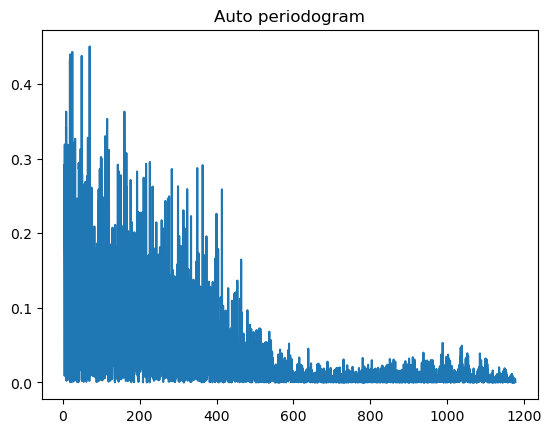

In [25]:
print(b['lcperiod_solution'])
plt.plot(b.get_value('period@lcperiod_solution'), b.get_value('power@lcperiod_solution'))
plt.title("Auto periodogram")
plt.show()

In [11]:
b.add_solver('estimator.lc_periodogram', algorithm='ls', solver='lcperiod_manual', overwrite=True)
b.set_value(qualifier='sample_mode', solver='lcperiod_manual', value='manual')
b.set_value(qualifier='sample_periods', solver='lcperiod_manual', value=phoebe.linspace(0.04, 0.5, 1000)*u.d)
print(b['lcperiod_manual'])

ParameterSet: 7 parameters
   comments@lcperiod_manual@so...: 
   use_server@lcperiod_manual@...: none
   algorithm@lcperiod_manual@s...: ls
   lc_datasets@lcperiod_manual...: ['*']
   component@lcperiod_manual@s...: binary
   sample_mode@lcperiod_manual...: manual
   sample_periods@lcperiod_man...: [0.04       0.04046046 0.04092092
 ... 0.49907908 0.49953954
 0.5       ] d


ParameterSet: 17 parameters
   comments@lcperiod_manual@so...: 
   use_server@lcperiod_manual@...: none
   algorithm@lcperiod_manual@s...: ls
   lc_datasets@lcperiod_manual...: ['*']
   component@lcperiod_manual@s...: binary
   sample_mode@lcperiod_manual...: manual
   sample_periods@lcperiod_man...: [0.04       0.04046046 0.04092092
 ... 0.49907908 0.49953954
 0.5       ] d
R  period@lcperiod_manual@lcpe...: [0.5
 0.49953954
 0.49907908 ...
 0.04092092
 0.04046046
 0.04      ] d
R  power@lcperiod_manual@lcper...: [0.05916441
 0.05940739
 0.0596494  ...
 0.46735979
 0.20320697
 0.08574171]
   period_factor@lcperiod_manu...: 1.0
R  fitted_twigs@lcperiod_manua...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_manu...: [0.04092092092092092]
R  fitted_units@lcperiod_manua...: ['d']
   adopt_parameters@lcperiod_m...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_manua...: True
   comments@lcperiod_manual@lc...: 


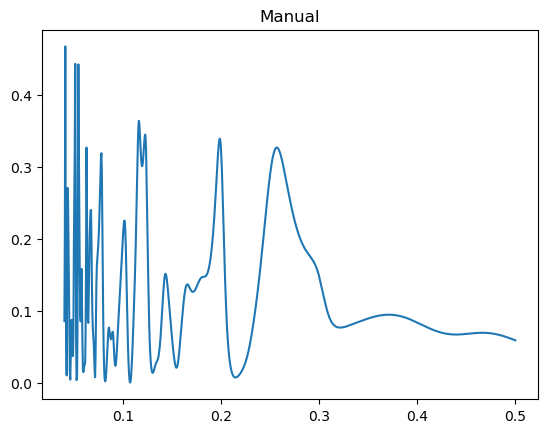

In [26]:
b.run_solver('lcperiod_manual', solution='lcperiod_manual_solution', overwrite=True)
print(b['lcperiod_manual'])
plt.plot(b.get_value('period@lcperiod_manual_solution'), b.get_value('power@lcperiod_manual_solution'))
plt.title("Manual")
plt.show()

In [14]:
printFittedVals(b, 'lcperiod_solution')
printFittedVals(b, 'lcperiod_manual_solution')

period@binary@orbit@component = 69.70 d
period@binary@orbit@component = 0.04 d


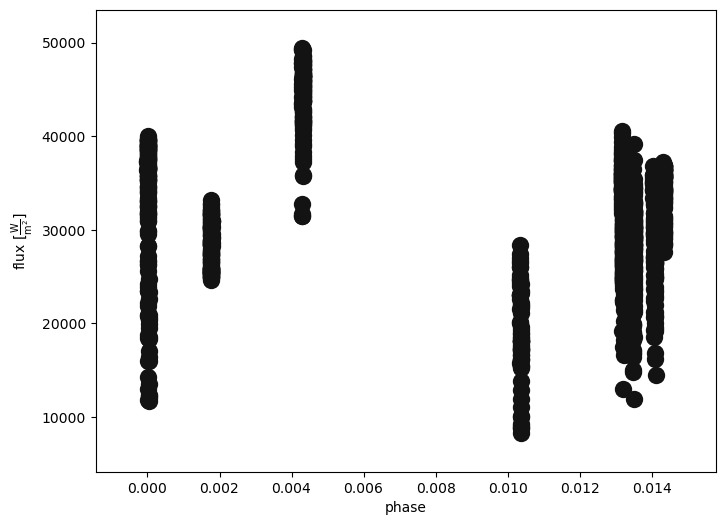

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [19]:
b.adopt_solution('lcperiod_solution')
b.plot(x='phase', show=True)

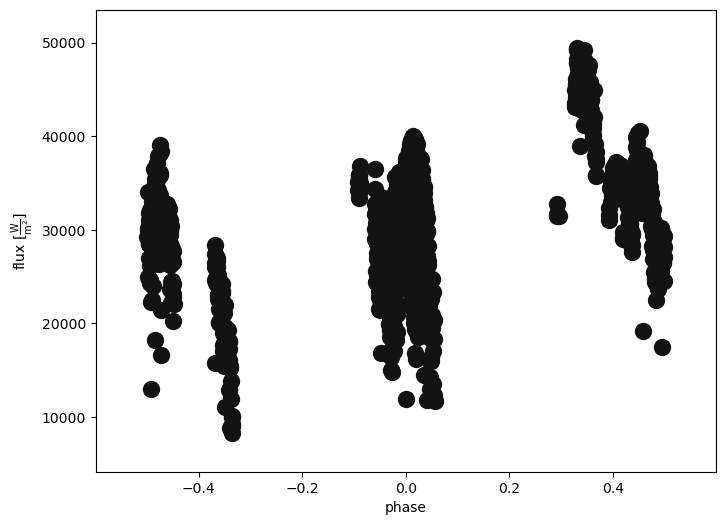

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [24]:
b.adopt_solution('lcperiod_manual_solution')
b.plot(x='phase', show=True)

## Manual period calculated from `qphot_timeseries_analysis` notebook

In [10]:
# b.remove_solution('lcperiod_solution')
manualPeriod = 3.416*u.hour
harmonic = 2
b.set_value(qualifier='period', component='binary', value=manualPeriod*harmonic)

6.832 h
0.2846666666666666 d


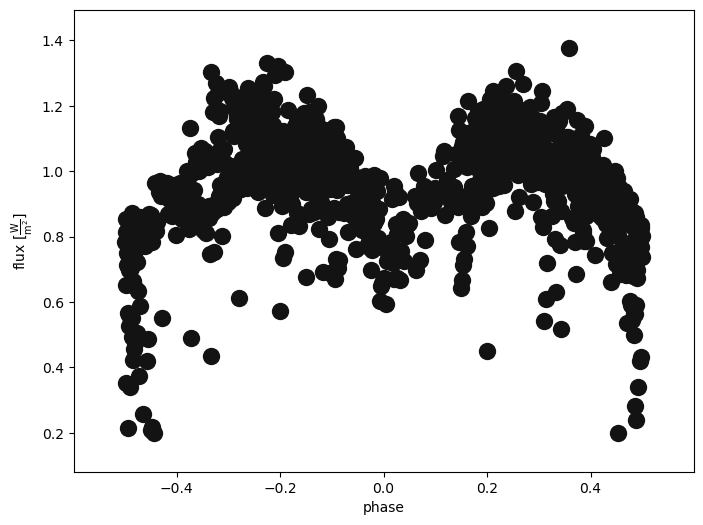

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [11]:
print(b.get_quantity(twig='period@orbit', unit=u.hour))
print(b.get_quantity(twig='period@orbit'))
b.plot(x='phase', show=True)

## Light curve geometry estimators

### EBAI

#### KNN

In [18]:
b.add_solver('estimator.ebai', ebai_method='knn', solver='ebai_knn', overwrite=True)
b.set_value(qualifier='phase_bin', solver='ebai_knn', value=False)
print(b['ebai_knn'])

ParameterSet: 6 parameters
         comments@ebai_knn@solver: 
       use_server@ebai_knn@solver: none
      lc_datasets@ebai_knn@solver: ['*']
        phase_bin@ebai_knn@solver: False
      ebai_method@ebai_knn@solver: knn
            orbit@ebai_knn@solver: binary


In [20]:
b.run_solver('ebai_knn', solution='ebai_knn_solution', overwrite=True)

Tue, 27 Jun 2023 15:44 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Tue, 27 Jun 2023 15:44 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid

<ParameterSet: 13 parameters | qualifiers: orbit, input_phases, fitted_units, input_fluxes, adopt_parameters, adopt_distributions, adopt_values, input_sigmas, fitted_twigs, fitted_values, ebai_phases, comments, ebai_fluxes>

In [21]:
printFittedVals(b, 'ebai_knn_solution')
print()
printFittedTwigsConstraints(b, 'ebai_knn_solution')

t0_supconj@binary@orbit@component = -0.09 d
teffratio@binary@orbit@component = 0.57 
incl@binary@orbit@component = 0.73 rad
fillout_factor@contact_envelope@envelope@component = 0.67 
q@binary@orbit@component = 7.03 

ParameterSet: 1 parameters
      t0_supconj@binary@component: 0.0 d
ParameterSet: 1 parameters
C      teffratio@binary@component: 1.0
ParameterSet: 1 parameters
            incl@binary@component: 90.0 deg
ParameterSet: 1 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
ParameterSet: 1 parameters
               q@binary@component: 1.0


In [39]:
print(b.get_quantity('incl@binary', unit=u.rad))
print(b['teffratio'])
print(b['fillout_factor'])
print(b['q'])
print(b['pot@contact_envelope'])
print(b['sma@binary'])
print(b['requiv@primary'])
print(b['requiv@secondary'])
print(b['requivratio'])

0.7338031836369036 rad
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.5722802200259326
                  Constrained by: 
                      Constrains: teff@primary@component
                      Related to: teff@secondary@component, teff@primary@component

Parameter: fillout_factor@contact_envelope@component
                       Qualifier: fillout_factor
                     Description: Fillout-factor of the envelope
                           Value: 0.6741662102851131
                  Constrained by: 
                      Constrains: pot@contact_envelope@component
                      Related to: q@binary@component, pot@contact_envelope@component

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 7.03278077865894
         

In [22]:
b.flip_constraint('teffratio', solve_for='teff@primary')
b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

In [15]:
print(b['pblum'])
print(b['pblum_mode'])

Parameter: pblum@primary@lc_iturbide@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.566370614359172 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: [component]pblum_mode:decoupled||[component]pblum_mode:component-coupled,[component]pblum_component:<component>

Parameter: pblum_mode@lc_iturbide@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: component-coupled
                         Choices: decoupled, component-coupled, dataset-coupled, dataset-scaled, absolute
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [32]:
# original = 12.566370614359172 W
b.set_value(qualifier='pblum', value=6.28*u.W)

In [37]:
print(b['mass'])
print(b['requiv'])
print(b['teffratio'])
print(b['teff'])
print(b['period'])
print(b.get_quantity('period@binary', unit=u.hour))

ParameterSet: 4 parameters
C          mass@primary@component: 0.7749646747165215 solMass
C        mass@secondary@component: 5.45015666848603 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
ParameterSet: 4 parameters
C        requiv@primary@component: 0.8612787441884051 solRad
C      requiv@secondary@component: 1.931495152542817 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2

Tue, 27 Jun 2023 16:08 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Tue, 27 Jun 2023 16:08 BUNDLE       WARNING 'primary' probably has a radiative atm (teff=10484K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
Tue, 27 Jun 2023 16:08 BUNDLE       WARNING 'primary' probably has a radiative atm (teff=10484K>=8000K), for which irrad_frac_refl_bol>0.8 (suggestion: 1.0) might be a better approx than irrad_frac_refl_bol=0.60.
100%|██████████| 1177/1177 [00:37<00:00, 31.15it/s]


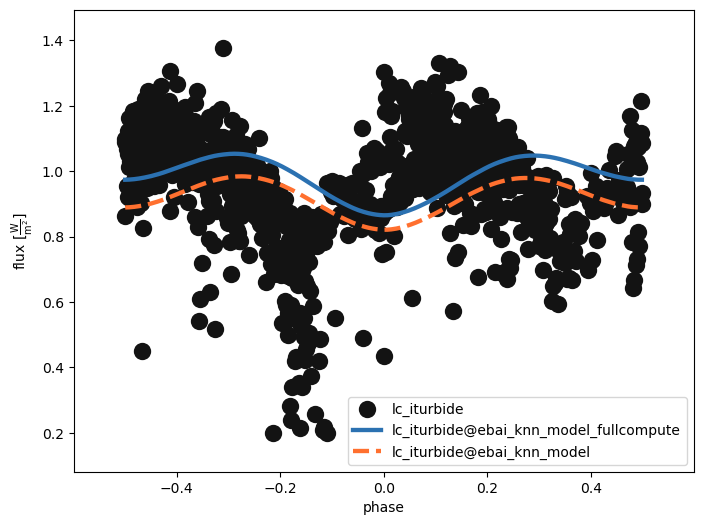

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [35]:
b.adopt_solution('ebai_knn_solution')
b.run_compute(compute='fast_compute', model='ebai_knn_model', overwrite=True)
b.plot(x='phase', show=True, legend=True)

Tue, 27 Jun 2023 16:42 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Tue, 27 Jun 2023 16:42 BUNDLE       WARNING ld_mode_bol of 'lookup' uses a bolometric passband which is not reliable for hot stars.  Consider using ld_mode_bol of manual and providing ld_coeffs instead.
Tue, 27 Jun 2023 16:42 BUNDLE       WARNING 'primary' probably has a radiative atm (teff=10484K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
Tue, 27 Jun 2023 16:42 BUNDLE       WARNING 'primary' probably has a radiative atm (teff=10484K>=8000K), for which irrad_frac_refl_bol>0.8 (suggestion: 1.0) might be a better approx than irrad_frac_refl_bol=0.60.


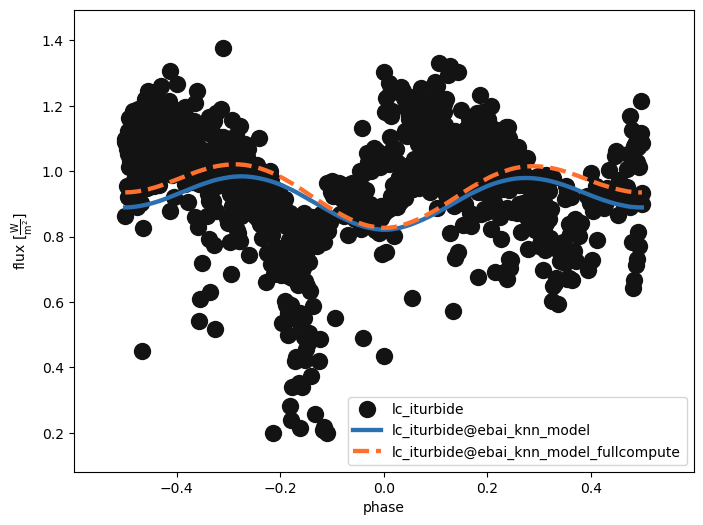

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [49]:
resetAtmosphere(b)
b.run_compute(compute='phoebe01', model='ebai_knn_model_fullcompute', overwrite=True)
b.plot(x='phase', show=True, legend=True)

In [52]:
print(b['gravb_bol'])
print(b['irrad_frac_refl_bol'])

ParameterSet: 2 parameters
      gravb_bol@primary@component: 0.32
    gravb_bol@secondary@component: 0.32
ParameterSet: 2 parameters
   irrad_frac_refl_bol@primary...: 0.6
   irrad_frac_refl_bol@seconda...: 0.6


In [56]:
# values recommended by PHOEBE when running forward compute
b.set_value(qualifier='gravb_bol', component='primary', value=0.9)
b.set_value(qualifier='irrad_frac_refl_bol', component='primary', value=1.0)

## Optimizers

### Nelder-Mead

In [71]:
b.add_solver('optimizer.nelder_mead',  solver='opt_nm_fast', compute='fast_compute', maxiter=100, overwrite=True,
             fit_parameters=['t0_supconj@binary', 'incl@binary', 'q', 'period@binary'])
print(b['opt_nm_fast'])

ParameterSet: 24 parameters
R  fitted_twigs@fast_compute@o...: ['t0_supconj@binary@orbit@component' 'incl@binary@orbit@component'
 'q@binary@orbit@component']
   adopt_parameters@fast_compu...: ['t0_supconj@binary@orbit@component', 'incl@binary@orbit@component', 'q@binary@orbit@component']
   adopt_distributions@fast_co...: False
   adopt_values@fast_compute@o...: True
R  message@opt_nm_fast_solutio...: Optimization terminated successfully.
R  niter@opt_nm_fast_solution@...: 107
R  success@opt_nm_fast_solutio...: True
R  initial_values@opt_nm_fast_...: [-0.09466398067027329 42.043825415657885 7.03278077865894]
R  fitted_values@fast_compute@...: [-0.13572069329244596 59.45584455609509 9.772073015581366]
R  fitted_units@fast_compute@o...: ['d' 'deg' '']
   comments@fast_compute@opt_n...: 
      comments@opt_nm_fast@solver: 
    use_server@opt_nm_fast@solver: compute
       compute@opt_nm_fast@solver: fast_compute
   expose_lnprobabilities@opt_...: False
   continue_from@opt_nm_fast@s...:

In [77]:
avoidAtmosphereErrors(b)
logger.setLevel('ERROR')
b.run_solver('opt_nm_fast', solution='opt_nm_fast_solution', overwrite=True)
logger.setLevel('WARNING')

  4%|▍         | 16/400 [25:34<10:13:37, 95.88s/it] 


KeyboardInterrupt: 

Tue, 27 Jun 2023 23:19 BUNDLE       WARNING applying passed solution (opt_nm_fast_solution) to sample_from
Tue, 27 Jun 2023 23:19 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@opt_nm_fast_solution=False
Tue, 27 Jun 2023 23:19 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Tue, 27 Jun 2023 23:19 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1


ParameterSet: 3 parameters
   t0_supconj@binary@orbit@com...: -0.1314437464903475 d
      incl@binary@orbit@component: 60.6815727435432 deg
         q@binary@orbit@component: 9.753109297203029


  0%|          | 0/1 [00:00<?, ?it/s]Tue, 27 Jun 2023 23:19 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Tue, 27 Jun 2023 23:19 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Tue, 27 Jun 2023 23:19 PASSBANDS    W

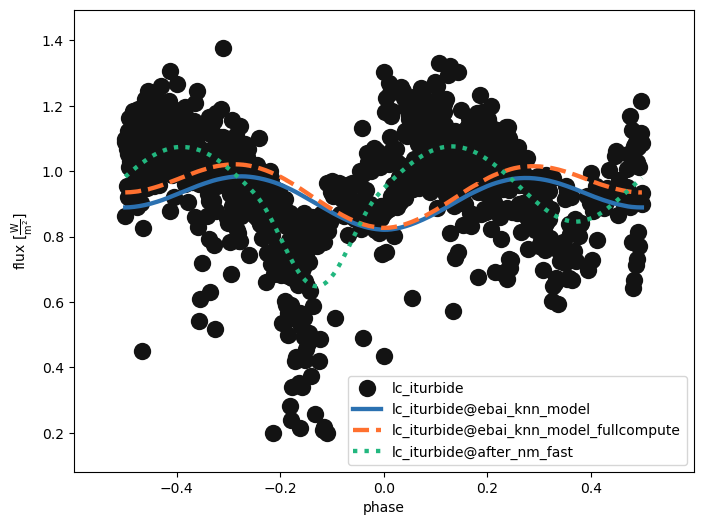

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [ ]:
print(b.adopt_solution('opt_nm_fast_solution', trial_run=True))
b.run_compute('fast_compute', solution='opt_nm_fast_solution', model='after_nm_fast', overwrite=True)

b.plot(x='phase', show=True, legend=True)
# b.plot(x='phase', y='residuals', show=True, legend=True)